# Method 1 - Best Ideas High Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Calculate Market Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] > popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

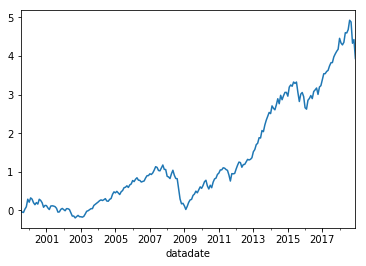

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.292309
2000-12-31   -0.124536
2001-12-31   -0.069006
2002-12-31   -0.203084
2003-12-31    0.416538
2004-12-31    0.246833
2005-12-31    0.137909
2006-12-31    0.128342
2007-12-31    0.082551
2008-12-31   -0.424347
2009-12-31    0.359019
2010-12-31    0.199491
2011-12-31    0.013090
2012-12-31    0.207864
2013-12-31    0.496045
2014-12-31    0.146410
2015-12-31   -0.026459
2016-12-31    0.071367
2017-12-31    0.222978
2018-12-31   -0.046651
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     552.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.58e-116
Time:                        16:10:51   Log-Likelihood:                 664.76
No. Observations:                 234   AIC:                            -1320.
Df Residuals:                     229   BIC:                            -1302.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.056      0.003       0.001       0.005
mktrf          0.9529      0.027     35.781      0.000       0.900       1.005
me             0.2724      0.031      8.792      0.000       0.211       0.333
ia            -0.1547      0.047     -3.286      0.001      -0.247      -0.062
roe            0.1048      0.040      2.599      0.010       0.025       0.184
==============================================================================
Omnibus:                       59.086   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.213
Skew:                           0.681   Prob(JB):                    5.35e-110
Kurtosis:                      10.054   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     428.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.31e-105
Time:                        16:10:51   Log-Likelihood:                 664.76
No. Observations:                 234   AIC:                            -1320.
Df Residuals:                     229   BIC:                            -1302.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.145      0.002       0.001       0.005
mktrf          0.9529      0.031     30.485      0.000       0.892       1.014
me             0.2724      0.032      8.570      0.000       0.210       0.335
ia            -0.1547      0.107     -1.440      0.150      -0.365       0.056
roe            0.1048      0.048      2.166      0.030       0.010       0.200
==============================================================================
Omnibus:                       59.086   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.213
Skew:                           0.681   Prob(JB):                    5.35e-110
Kurtosis:                      10.054   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     438.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.58e-106
Time:                        16:10:51   Log-Likelihood:                 664.76
No. Observations:                 234   AIC:                            -1320.
Df Residuals:                     229   BIC:                            -1302.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.847      0.004       0.001       0.005
mktrf          0.9529      0.030     31.800      0.000       0.894       1.012
me             0.2724      0.032      8.396      0.000       0.209       0.336
ia            -0.1547      0.101     -1.525      0.127      -0.354       0.044
roe            0.1048      0.046      2.257      0.024       0.014       0.196
==============================================================================
Omnibus:                       59.086   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.213
Skew:                           0.681   Prob(JB):                    5.35e-110
Kurtosis:                      10.054   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     389.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.67e-109
Time:                        16:10:52   Log-Likelihood:                 651.95
No. Observations:                 234   AIC:                            -1292.
Df Residuals:                     228   BIC:                            -1271.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.260      0.001       0.001       0.005
mktrf          0.9293      0.028     32.901      0.000       0.874       0.985
smb            0.2612      0.037      7.007      0.000       0.188       0.335
hml           -0.0690      0.044     -1.569      0.118      -0.156       0.018
rmw            0.0018      0.050      0.037      0.971      -0.096       0.100
cma           -0.0262      0.063     -0.415      0.679      -0.151       0.098
==============================================================================
Omnibus:                       42.537   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.313
Skew:                           0.370   Prob(JB):                     1.39e-71
Kurtosis:                       8.738   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.09e-126
Time:                        16:10:52   Log-Likelihood:                 651.95
No. Observations:                 234   AIC:                            -1292.
Df Residuals:                     228   BIC:                            -1271.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      2.906      0.004       0.001       0.006
mktrf          0.9293      0.037     24.927      0.000       0.856       1.002
smb            0.2612      0.042      6.259      0.000       0.179       0.343
hml           -0.0690      0.071     -0.965      0.334      -0.209       0.071
rmw            0.0018      0.058      0.031      0.975      -0.112       0.116
cma           -0.0262      0.141     -0.186      0.853      -0.303       0.251
==============================================================================
Omnibus:                       42.537   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.313
Skew:                           0.370   Prob(JB):                     1.39e-71
Kurtosis:                       8.738   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     687.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.54e-135
Time:                        16:10:52   Log-Likelihood:                 651.95
No. Observations:                 234   AIC:                            -1292.
Df Residuals:                     228   BIC:                            -1271.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      2.654      0.008       0.001       0.006
mktrf          0.9293      0.038     24.409      0.000       0.855       1.004
smb            0.2612      0.041      6.431      0.000       0.182       0.341
hml           -0.0690      0.077     -0.891      0.373      -0.221       0.083
rmw            0.0018      0.056      0.033      0.974      -0.108       0.112
cma           -0.0262      0.149     -0.176      0.860      -0.318       0.266
==============================================================================
Omnibus:                       42.537   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.313
Skew:                           0.370   Prob(JB):                     1.39e-71
Kurtosis:                       8.738   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     617.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.25e-121
Time:                        16:10:52   Log-Likelihood:                 676.67
No. Observations:                 234   AIC:                            -1343.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.739      0.007       0.001       0.004
mktrf          1.0111      0.023     43.393      0.000       0.965       1.057
smb            0.1836      0.029      6.312      0.000       0.126       0.241
hml            0.0031      0.029      0.108      0.914      -0.054       0.060
umd            0.1491      0.019      7.866      0.000       0.112       0.186
==============================================================================
Omnibus:                       24.924   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.874
Skew:                           0.096   Prob(JB):                     6.89e-26
Kurtosis:                       6.442   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     577.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.56e-118
Time:                        16:10:52   Log-Likelihood:                 676.67
No. Observations:                 234   AIC:                            -1343.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.636      0.008       0.001       0.004
mktrf          1.0111      0.036     28.440      0.000       0.941       1.081
smb            0.1836      0.035      5.220      0.000       0.115       0.253
hml            0.0031      0.053      0.059      0.953      -0.102       0.108
umd            0.1491      0.034      4.411      0.000       0.083       0.215
==============================================================================
Omnibus:                       24.924   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.874
Skew:                           0.096   Prob(JB):                     6.89e-26
Kurtosis:                       6.442   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     637.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.66e-123
Time:                        16:10:52   Log-Likelihood:                 676.67
No. Observations:                 234   AIC:                            -1343.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.559      0.010       0.001       0.004
mktrf          1.0111      0.035     28.859      0.000       0.942       1.080
smb            0.1836      0.037      4.964      0.000       0.111       0.256
hml            0.0031      0.054      0.058      0.954      -0.103       0.109
umd            0.1491      0.034      4.448      0.000       0.083       0.215
==============================================================================
Omnibus:                       24.924   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.874
Skew:                           0.096   Prob(JB):                     6.89e-26
Kurtosis:                       6.442   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     227.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.27e-53
Time:                        16:10:52   Log-Likelihood:                 315.83
No. Observations:                 120   AIC:                            -621.7
Df Residuals:                     115   BIC:                            -607.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.620      0.108      -0.001       0.006
mktrf          1.0057      0.046     21.942      0.000       0.915       1.096
me             0.2891      0.045      6.385      0.000       0.199       0.379
ia            -0.1428      0.071     -2.015      0.046      -0.283      -0.002
roe            0.1959      0.063      3.122      0.002       0.072       0.320
==============================================================================
Omnibus:                       31.859   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.762
Skew:                           0.764   Prob(JB):                     4.48e-31
Kurtosis:                       8.061   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     182.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.75e-49
Time:                        16:10:52   Log-Likelihood:                 315.83
No. Observations:                 120   AIC:                            -621.7
Df Residuals:                     115   BIC:                            -607.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.047      0.041       0.000       0.005
mktrf          1.0057      0.049     20.603      0.000       0.910       1.101
me             0.2891      0.040      7.224      0.000       0.211       0.367
ia            -0.1428      0.133     -1.070      0.285      -0.404       0.119
roe            0.1959      0.056      3.504      0.000       0.086       0.305
==============================================================================
Omnibus:                       31.859   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.762
Skew:                           0.764   Prob(JB):                     4.48e-31
Kurtosis:                       8.061   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     215.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.83e-52
Time:                        16:10:52   Log-Likelihood:                 315.83
No. Observations:                 120   AIC:                            -621.7
Df Residuals:                     115   BIC:                            -607.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      1.984      0.047    3.33e-05       0.005
mktrf          1.0057      0.039     25.986      0.000       0.930       1.082
me             0.2891      0.040      7.146      0.000       0.210       0.368
ia            -0.1428      0.124     -1.149      0.250      -0.386       0.101
roe            0.1959      0.039      5.016      0.000       0.119       0.272
==============================================================================
Omnibus:                       31.859   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.762
Skew:                           0.764   Prob(JB):                     4.48e-31
Kurtosis:                       8.061   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     149.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.52e-48
Time:                        16:10:52   Log-Likelihood:                 305.88
No. Observations:                 120   AIC:                            -599.8
Df Residuals:                     114   BIC:                            -583.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.100      0.038       0.000       0.008
mktrf          0.9702      0.053     18.398      0.000       0.866       1.075
smb            0.2753      0.060      4.609      0.000       0.157       0.394
hml           -0.1134      0.073     -1.549      0.124      -0.258       0.032
rmw            0.0692      0.086      0.801      0.425      -0.102       0.240
cma            0.0455      0.095      0.481      0.631      -0.142       0.233
==============================================================================
Omnibus:                       16.561   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.421
Skew:                           0.318   Prob(JB):                     2.51e-12
Kurtosis:                       6.206   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     203.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.08e-55
Time:                        16:10:52   Log-Likelihood:                 305.88
No. Observations:                 120   AIC:                            -599.8
Df Residuals:                     114   BIC:                            -583.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.085      0.037       0.000       0.008
mktrf          0.9702      0.073     13.242      0.000       0.827       1.114
smb            0.2753      0.062      4.422      0.000       0.153       0.397
hml           -0.1134      0.116     -0.979      0.328      -0.340       0.114
rmw            0.0692      0.107      0.647      0.518      -0.140       0.279
cma            0.0455      0.178      0.255      0.799      -0.304       0.395
==============================================================================
Omnibus:                       16.561   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.421
Skew:                           0.318   Prob(JB):                     2.51e-12
Kurtosis:                       6.206   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     229.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.22e-58
Time:                        16:10:52   Log-Likelihood:                 305.88
No. Observations:                 120   AIC:                            -599.8
Df Residuals:                     114   BIC:                            -583.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      1.936      0.053   -4.85e-05       0.008
mktrf          0.9702      0.074     13.105      0.000       0.825       1.115
smb            0.2753      0.058      4.737      0.000       0.161       0.389
hml           -0.1134      0.127     -0.892      0.372      -0.363       0.136
rmw            0.0692      0.109      0.635      0.525      -0.144       0.283
cma            0.0455      0.187      0.244      0.807      -0.320       0.411
==============================================================================
Omnibus:                       16.561   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.421
Skew:                           0.318   Prob(JB):                     2.51e-12
Kurtosis:                       6.206   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     276.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.26e-58
Time:                        16:10:52   Log-Likelihood:                 326.38
No. Observations:                 120   AIC:                            -642.8
Df Residuals:                     115   BIC:                            -628.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.642      0.009       0.001       0.007
mktrf          1.0721      0.037     28.993      0.000       0.999       1.145
smb            0.1411      0.042      3.351      0.001       0.058       0.224
hml            0.0147      0.042      0.349      0.728      -0.069       0.098
umd            0.1880      0.026      7.230      0.000       0.136       0.239
==============================================================================
Omnibus:                       10.424   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               25.206
Skew:                          -0.120   Prob(JB):                     3.36e-06
Kurtosis:                       5.232   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     433.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.33e-68
Time:                        16:10:52   Log-Likelihood:                 326.38
No. Observations:                 120   AIC:                            -642.8
Df Residuals:                     115   BIC:                            -628.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      3.170      0.002       0.002       0.007
mktrf          1.0721      0.047     22.725      0.000       0.980       1.165
smb            0.1411      0.041      3.416      0.001       0.060       0.222
hml            0.0147      0.064      0.230      0.818      -0.111       0.140
umd            0.1880      0.037      5.124      0.000       0.116       0.260
==============================================================================
Omnibus:                       10.424   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               25.206
Skew:                          -0.120   Prob(JB):                     3.36e-06
Kurtosis:                       5.232   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     704.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.18e-80
Time:                        16:10:52   Log-Likelihood:                 326.38
No. Observations:                 120   AIC:                            -642.8
Df Residuals:                     115   BIC:                            -628.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      3.392      0.001       0.002       0.006
mktrf          1.0721      0.039     27.521      0.000       0.996       1.148
smb            0.1411      0.039      3.660      0.000       0.066       0.217
hml            0.0147      0.063      0.233      0.816      -0.109       0.139
umd            0.1880      0.028      6.637      0.000       0.132       0.244
==============================================================================
Omnibus:                       10.424   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               25.206
Skew:                          -0.120   Prob(JB):                     3.36e-06
Kurtosis:                       5.232   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     578.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.09e-72
Time:                        16:10:52   Log-Likelihood:                 386.58
No. Observations:                 114   AIC:                            -763.2
Df Residuals:                     109   BIC:                            -749.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      4.321      0.000       0.002       0.005
mktrf          0.9123      0.024     37.240      0.000       0.864       0.961
me             0.2393      0.038      6.327      0.000       0.164       0.314
ia            -0.2557      0.052     -4.873      0.000      -0.360      -0.152
roe           -0.1286      0.046     -2.790      0.006      -0.220      -0.037
==============================================================================
Omnibus:                        0.146   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.930   Jarque-Bera (JB):                0.291
Skew:                          -0.065   Prob(JB):                        0.865
Kurtosis:                       2.789   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     867.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.21e-81
Time:                        16:10:52   Log-Likelihood:                 386.58
No. Observations:                 114   AIC:                            -763.2
Df Residuals:                     109   BIC:                            -749.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.937      0.003       0.001       0.006
mktrf          0.9123      0.018     51.478      0.000       0.878       0.947
me             0.2393      0.037      6.410      0.000       0.166       0.312
ia            -0.2557      0.058     -4.441      0.000      -0.369      -0.143
roe           -0.1286      0.054     -2.389      0.017      -0.234      -0.023
==============================================================================
Omnibus:                        0.146   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.930   Jarque-Bera (JB):                0.291
Skew:                          -0.065   Prob(JB):                        0.865
Kurtosis:                       2.789   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1264.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.58e-90
Time:                        16:10:52   Log-Likelihood:                 386.58
No. Observations:                 114   AIC:                            -763.2
Df Residuals:                     109   BIC:                            -749.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      2.431      0.015       0.001       0.006
mktrf          0.9123      0.016     55.567      0.000       0.880       0.944
me             0.2393      0.036      6.672      0.000       0.169       0.310
ia            -0.2557      0.060     -4.258      0.000      -0.373      -0.138
roe           -0.1286      0.051     -2.504      0.012      -0.229      -0.028
==============================================================================
Omnibus:                        0.146   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.930   Jarque-Bera (JB):                0.291
Skew:                          -0.065   Prob(JB):                        0.865
Kurtosis:                       2.789   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     525.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.66e-74
Time:                        16:10:52   Log-Likelihood:                 394.03
No. Observations:                 114   AIC:                            -776.1
Df Residuals:                     108   BIC:                            -759.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.471      0.001       0.001       0.004
mktrf          0.9202      0.022     41.854      0.000       0.877       0.964
smb            0.2193      0.036      6.144      0.000       0.149       0.290
hml           -0.0741      0.046     -1.627      0.107      -0.164       0.016
rmw           -0.2288      0.056     -4.104      0.000      -0.339      -0.118
cma           -0.1892      0.071     -2.673      0.009      -0.329      -0.049
==============================================================================
Omnibus:                        0.402   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.818   Jarque-Bera (JB):                0.460
Skew:                          -0.138   Prob(JB):                        0.795
Kurtosis:                       2.855   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     475.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.07e-72
Time:                        16:10:52   Log-Likelihood:                 394.03
No. Observations:                 114   AIC:                            -776.1
Df Residuals:                     108   BIC:                            -759.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.527      0.011       0.001       0.005
mktrf          0.9202      0.020     45.612      0.000       0.881       0.960
smb            0.2193      0.029      7.693      0.000       0.163       0.275
hml           -0.0741      0.043     -1.704      0.088      -0.159       0.011
rmw           -0.2288      0.055     -4.126      0.000      -0.337      -0.120
cma           -0.1892      0.083     -2.271      0.023      -0.352      -0.026
==============================================================================
Omnibus:                        0.402   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.818   Jarque-Bera (JB):                0.460
Skew:                          -0.138   Prob(JB):                        0.795
Kurtosis:                       2.855   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     416.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.35e-69
Time:                        16:10:52   Log-Likelihood:                 394.03
No. Observations:                 114   AIC:                            -776.1
Df Residuals:                     108   BIC:                            -759.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.058      0.040       0.000       0.005
mktrf          0.9202      0.021     44.118      0.000       0.879       0.961
smb            0.2193      0.024      8.972      0.000       0.171       0.267
hml           -0.0741      0.044     -1.701      0.089      -0.159       0.011
rmw           -0.2288      0.063     -3.657      0.000      -0.351      -0.106
cma           -0.1892      0.078     -2.419      0.016      -0.342      -0.036
==============================================================================
Omnibus:                        0.402   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.818   Jarque-Bera (JB):                0.460
Skew:                          -0.138   Prob(JB):                        0.795
Kurtosis:                       2.855   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     525.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.19e-70
Time:                        16:10:52   Log-Likelihood:                 381.32
No. Observations:                 114   AIC:                            -752.6
Df Residuals:                     109   BIC:                            -739.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.156      0.033       0.000       0.004
mktrf          0.9470      0.024     38.951      0.000       0.899       0.995
smb            0.2674      0.038      7.055      0.000       0.192       0.343
hml           -0.0942      0.039     -2.414      0.017      -0.172      -0.017
umd            0.0244      0.029      0.830      0.408      -0.034       0.083
==============================================================================
Omnibus:                        2.298   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.317   Jarque-Bera (JB):                1.736
Skew:                          -0.250   Prob(JB):                        0.420
Kurtosis:                       3.341   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     890.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.15e-82
Time:                        16:10:52   Log-Likelihood:                 381.32
No. Observations:                 114   AIC:                            -752.6
Df Residuals:                     109   BIC:                            -739.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.667      0.096      -0.000       0.004
mktrf          0.9470      0.016     59.003      0.000       0.916       0.978
smb            0.2674      0.036      7.370      0.000       0.196       0.339
hml           -0.0942      0.036     -2.582      0.010      -0.166      -0.023
umd            0.0244      0.022      1.129      0.259      -0.018       0.067
==============================================================================
Omnibus:                        2.298   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.317   Jarque-Bera (JB):                1.736
Skew:                          -0.250   Prob(JB):                        0.420
Kurtosis:                       3.341   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1217.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.94e-89
Time:                        16:10:52   Log-Likelihood:                 381.32
No. Observations:                 114   AIC:                            -752.6
Df Residuals:                     109   BIC:                            -739.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.419      0.156      -0.001       0.004
mktrf          0.9470      0.015     64.005      0.000       0.918       0.976
smb            0.2674      0.038      7.123      0.000       0.194       0.341
hml           -0.0942      0.032     -2.912      0.004      -0.158      -0.031
umd            0.0244      0.024      1.016      0.310      -0.023       0.072
==============================================================================
Omnibus:                        2.298   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.317   Jarque-Bera (JB):                1.736
Skew:                          -0.250   Prob(JB):                        0.420
Kurtosis:                       3.341   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""